In [1]:
# base
import scipy as sc
from scipy import sparse, io
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from matplotlib import pyplot as plt
# clustering and umap
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
import umap
from itertools import compress

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
from pandas.plotting import scatter_matrix

In [3]:
import scanpy as scp
import anndata

In [23]:
import sklearn

In [4]:
def read_mtx(prefix):
    mtx = io.mmread(infolder + ".counts.mtx")
    mtx = mtx.tocsr()
    with open(infolder + ".colnames.txt") as col:
        colnames = col.read().splitlines()
    col.close()
    with open(infolder + ".rownames.txt") as row:
        rownames = row.read().splitlines()
    row.close()
    return mtx, rownames, colnames

In [5]:
# from mtx
def preprocess_mtx(sparse_mtx, rownames, colnames, min_cell_sum=1000, min_region_sum=10):
    ## binarize
    nonzero_mask = np.array(sparse_mtx[sparse_mtx.nonzero()] > 1)[0]
    rows = sparse_mtx.nonzero()[0][nonzero_mask]
    cols = sparse_mtx.nonzero()[1][nonzero_mask]
    sparse_mtx[rows, cols] = 1
    
    ## filter low counts
    colmask = np.array(np.sum(sparse_mtx, axis = 0) >= min_cell_sum)[0]
    rowmask = np.array(np.sum(sparse_mtx, axis = 1) >= min_region_sum)
    rowmask = np.array([x[0] for x in rowmask])
    sparse_mtx = sparse_mtx[rowmask, :]
    sparse_mtx = sparse_mtx[:, colmask]
    
    ## create anndata
    row_subset = list(compress(rownames, rowmask))
    col_subset = list(compress(colnames, colmask))
    adata = anndata.AnnData(sparse_mtx.transpose(), 
                            obs=pd.DataFrame(col_subset), 
                            var=pd.DataFrame(row_subset))
    
    return adata

# from anndata
def preprocess_adata(adata, min_cell_sum=1000, min_region_sum=10):
    # binarize
    sparse_mtx = adata.X
    nonzero_mask = np.array(sparse_mtx[sparse_mtx.nonzero()] > 1)[0]
    rows = sparse_mtx.nonzero()[0][nonzero_mask]
    cols = sparse_mtx.nonzero()[1][nonzero_mask]
    sparse_mtx[rows, cols] = 1
    adata.x = sparse_mtx
    # save some QC
    scp.pp.calculate_qc_metrics(adata, inplace=True)
    # filter
    adata = adata[adata.obs.n_genes_by_counts >= min_cell_sum, :]
    adata = adata[:, adata.var.n_cells_by_counts >= min_region_sum]
    
    return adata

In [18]:
def runLSA(sparse_mtx, nPCs, scaleFactor): 
    #tf = (sparse_mtx.transpose() / sparse_mtx.sum(axis=0)).transpose()
    tf = sparse_mtx / sparse_mtx.sum(axis=0)
    tf = np.log1p(tf * scaleFactor)
    
    idf = np.log1p(sparse_mtx.shape[1] / sparse_mtx.sum(axis=1))
    tfidf = np.multiply(tf, idf)
    svd = TruncatedSVD(n_components=nPCs)
    pca = svd.fit(np.nan_to_num(tfidf, nan = 0.0))
    
    return pca, tfidf

## for anndata

def lsa_anndata(adata, n_pcs, scale_factor=None):
    mtx = sparse.csr_matrix(adata.X)
    lsa_out, tfidf = runLSA(mtx.transpose(), n_pcs, scale_factor)

    adata.X = np.squeeze(np.asarray(tfidf.transpose()))
    adata.obsm['X_pca'] = lsa_out.components_.transpose()
    adata.uns['pca_variance'] = lsa_out.explained_variance_
    adata.uns['pca_variance_ratio'] = lsa_out.explained_variance_ratio_
    adata.layers['raw_counts'] = mtx
    
    return adata


In [7]:
def UMAP_clustering(adata):
    
    # make umap on PCA
    lsa_out = adata.obsm['X_pca'].transpose()[1:, :]
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, spread=1.0, metric='euclidean', init = 'random')
    embeddings = reducer.fit_transform(lsa_out.transpose())
    adata.obsm['X_umap'] = embeddings
    
    # louvain (from scanpy)
    scp.pp.neighbors(adata)
    scp.tl.louvain(adata)
    cluster_id = [int(x) for x in adata.obs['louvain'].to_list()]
    
    # return
    return adata


In [ ]:
## ESC
infolder="/hpc/hub_oudenaarden/vbhardwaj/2019_scHiC/04_ESC_NPC/04_workflow_outputs/downstream/ESC_NPC_clustering/scDeepTools_filtered_ESC-NPC_peaks_counts"
mtx, row, col = read_mtx(infolder)
esc_adata = preprocess_mtx(mtx, row, col)

In [9]:
esc_adata.X

<1171x113748 sparse matrix of type '<class 'numpy.float32'>'
	with 4404275 stored elements in Compressed Sparse Column format>

In [ ]:
esc_adata = lsa_anndata(esc_adata, n_pcs=5, scale_factor=100000)

In [ ]:
esc_adata = UMAP_clustering(esc_adata)

In [75]:
esc = esc_adata.layers['raw_counts'].transpose()

In [83]:
tfidf_out = tfidf.fit_transform(esc)
svd = TruncatedSVD(n_components=5)
pca = svd.fit(tfidf_out)
pca.components_.shape

(5, 1171)

/home/vbhardwaj/programs/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


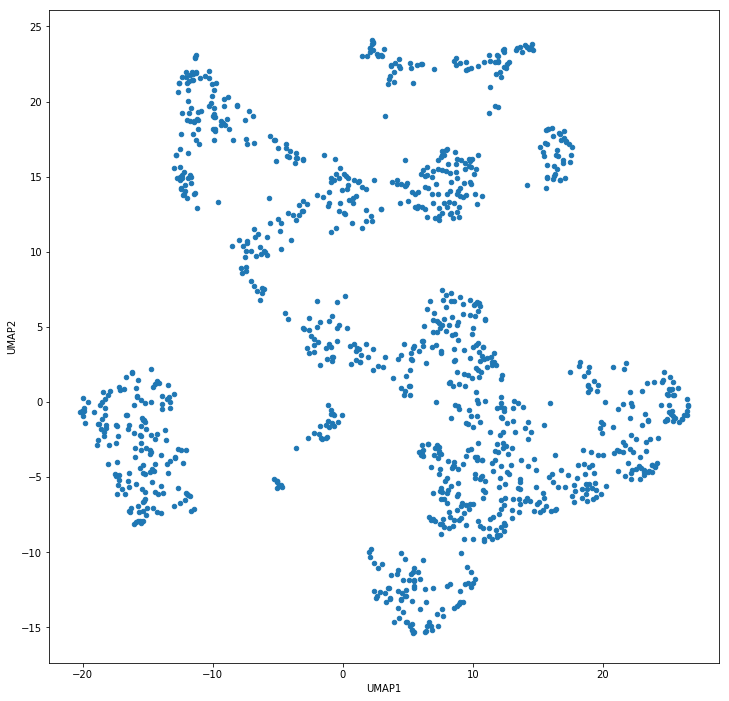

In [84]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, spread=5.0, metric='euclidean', init = 'random')
embeddings = reducer.fit_transform(pca.components_.transpose())
df = pd.DataFrame({'UMAP1': embeddings[:, 0],
              'UMAP2': embeddings[:, 1]
             })
df.plot.scatter('UMAP1', 'UMAP2')

works for ESC-NPC

## Run it on bone marrow

In [20]:
infolder="/hpc/hub_oudenaarden/vbhardwaj/2019_scHiC/05_bone_marrow/03_ctcf_k4me3_dChIC_run-1/counts/scDeepTools_filtered_counts_50kWindows"
mtx_bm = read_mtx(infolder)
ad_bm_mtx = preprocess_mtx(mtx_bm[0], mtx_bm[1], mtx_bm[2])

/home/vbhardwaj/programs/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
svd = TruncatedSVD(n_components=30)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

In [58]:
tfidf = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False)

In [77]:
ad_bm_mtx.X.transpose()

<49883x655 sparse matrix of type '<class 'numpy.float32'>'
	with 4381442 stored elements in Compressed Sparse Row format>

In [59]:
tfidf_out = tfidf.fit_transform(ad_bm_mtx.X.transpose())
pca = svd.fit(tfidf_out)
pca.components_.shape

In [ ]:
pd.DataFrame(np.array(np.sum(ad_bm_mtx.X.transpose(), axis = 0))[0]).describe()

matches the data frame description in R

In [ ]:
## check the same for tfIDF df
lsa_out, tfidf_bm = runLSA(ad_bm_mtx.X.transpose(), nPCs = 10, scaleFactor=100000)
svd = TruncatedSVD(n_components=30)
pca = svd.fit(tfidf_bm.transpose())

In [70]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, spread=5.0, metric='euclidean', init = 'random')

embeddings = reducer.fit_transform(pca.components_.transpose())

df = pd.DataFrame({'UMAP1': embeddings[:, 0],
              'UMAP2': embeddings[:, 1]
             })

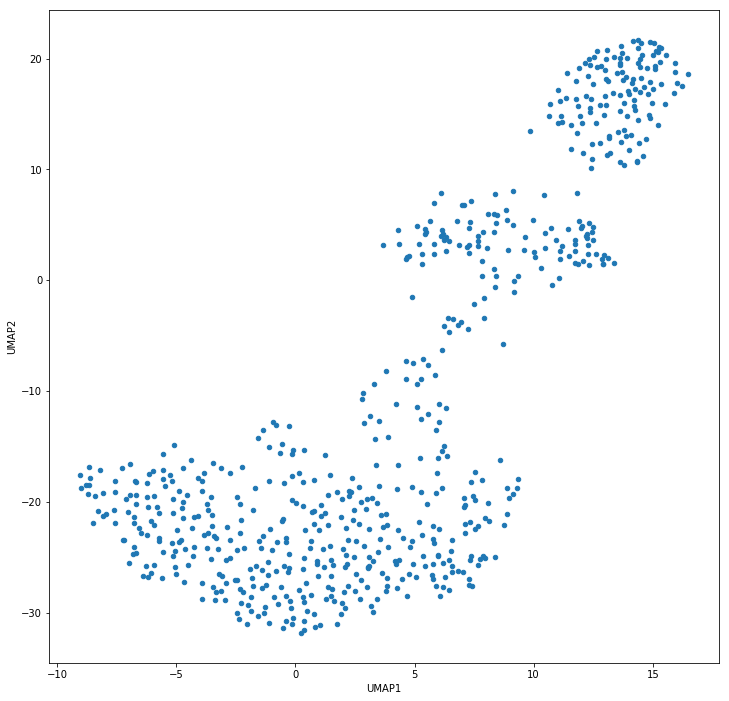

In [73]:
df.plot.scatter('UMAP1', 'UMAP2')

In [ ]:
cluster_id = ad_bm_mtx.obs.louvain.to_list()
cluster_id = [int(x) for x in cluster_id]
embeddings = ad_bm_mtx.obsm['X_umap']

df = pd.DataFrame({'Cluster': cluster_id,
              'UMAP1': embeddings[:, 0],
              'UMAP2': embeddings[:, 1]
             })

In [ ]:
df.plot.scatter('UMAP1', 'UMAP2')

In [ ]:
def plotUMAP(embeddings, cluster_id):
    plotWidth = 10
    plotHeight = 10
    plotFile = "test.png"
    plotFileFormat = 'png'
    ## plotting mods
    plt.rcParams['font.size'] = 8.0
    # convert cm values to inches
    fig = plt.figure(figsize=(plotWidth / 2.54, plotHeight / 2.54))
    fig.suptitle('LSA-UMAP', y=(1 - (0.06 / plotHeight)))
    plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=[sns.color_palette()[x] for x in cluster_id])
    plt.tight_layout()
    plt.savefig(plotFile, dpi=200, format=plotFileFormat)
    plt.close()
    
    return None


## LSA-clustering from anndata

In [ ]:
ad_bm = anndata.read_h5ad("/hpc/hub_oudenaarden/vbhardwaj/2019_scHiC/05_bone_marrow/03_ctcf_k4me3_dChIC_run-1/counts/scDeepTools_filtered_counts_50kWindows.h5ad")

In [ ]:
ad_bm = preprocess_adata(ad_bm)

In [ ]:
ad_bm = lsa_anndata(ad_bm, 20, 100000)

In [ ]:
umap_bm_ad = UMAP_clustering(ad_bm)

In [ ]:
cluster_id = ad_bm.obs.louvain.to_list()
cluster_id = [int(x) for x in cluster_id]
embeddings = ad_bm.obsm['X_umap']

df = pd.DataFrame({'UMAP1': embeddings[:, 0],
                  'UMAP2': embeddings[:, 1],
                  'Cluster': cluster_id,
                 })

df.index = ad_bm.obs.index

In [ ]:
ad_bm.

**Match with R**